Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-vgg19.ipynb)
## Code Modules, Classes & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from tensorflow import image as timage
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn as tnn
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" if torch.cuda.is_available() 
                 else "cpu")

In [2]:
class TData(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.X[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
class VGG19(tnn.Module):
    def __init__(self,num_classes):
        super(VGG19,self).__init__()    
        self.block1=tnn.Sequential(
            tnn.Conv2d(in_channels=3,out_channels=64,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1), 
            tnn.ReLU(),
            tnn.Conv2d(in_channels=64,out_channels=64,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) )        
        self.block2=tnn.Sequential(
            tnn.Conv2d(in_channels=64,out_channels=128,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=128,out_channels=128,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) )      
        self.block3=tnn.Sequential(
            tnn.Conv2d(in_channels=128,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=256,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),        
            tnn.Conv2d(in_channels=256,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=256,out_channels=256,
                       kernel_size=(3,3),stride=(1,1),
                      padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) )         
        self.block4=tnn.Sequential(   
            tnn.Conv2d(in_channels=256,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),        
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),        
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),   
            tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) )       
        self.block5=tnn.Sequential(
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),            
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),            
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),
            tnn.Conv2d(in_channels=512,out_channels=512,
                       kernel_size=(3,3),stride=(1,1),
                       padding=1),
            tnn.ReLU(),   
            tnn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) )        
        self.classifier=tnn.Sequential(
            tnn.Linear(512,4096),
            tnn.ReLU(True),
            tnn.Linear(4096,4096),
            tnn.ReLU(True),
            tnn.Linear(4096,num_classes) )            
        for m in self.modules():
            if isinstance(m,torch.nn.Conv2d):
                m.weight.detach().normal_(0,.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0,.05)
                m.bias.detach().detach().zero_()      
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        logits=self.classifier(x.view(-1,512))
        probs=tnn.functional.softmax(logits,dim=1)
        return logits,probs

In [4]:
def resize_display(x_train,y_train,
                   x_test,y_test,pixels):
    x_train=np.array(timage.resize(x_train,[pixels,pixels]))
    x_test=np.array(timage.resize(x_test,[pixels,pixels]))
    N=len(y_train); shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    x_train,y_train=x_train[shuffle_ids],y_train[shuffle_ids]
    N=len(y_test); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x_test,y_test=x_test[shuffle_ids],y_test[shuffle_ids]
    x_train=x_train.reshape(-1,3,pixels,pixels)
    x_test=x_test.reshape(-1,3,pixels,pixels)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)    
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]
def display_examples(data_loader,pixels):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(pixels,pixels,3))
        break
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100

In [5]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [11]:
pixels=48
fpath='./input/tf-cats-vs-dogs/'
f='CatDogImages.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x_test=np.array(f[keys[0]])
y_test=np.array(f[keys[1]]).reshape(-1)
x_train=np.array(f[keys[2]])
y_train=np.array(f[keys[3]]).reshape(-1)
[[x_train,x_valid,x_test],
 [y_train,y_valid,y_test]]=\
resize_display(x_train,y_train,x_test,y_test,pixels)

['test_images', 'test_labels', 'train_images', 'train_labels']


,train,valid,test
image shape,"(18610, 3, 48, 48)","(2326, 3, 48, 48)","(2326, 3, 48, 48)"
image type,float32,float32,float32
label shape,"(18610,)","(2326,)","(2326,)"
label type,int32,int32,int32


Image dimensions: torch.Size([128, 3, 48, 48])
Label dimensions: torch.Size([128])


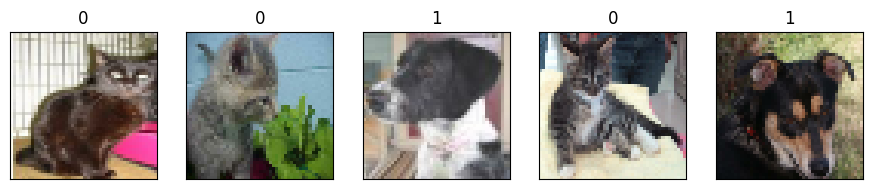

In [12]:
random_seed=1; batch_size=128;
train=TData(x_train,y_train)
valid=TData(x_valid,y_valid)
test=TData(x_test,y_test)
train_loader=tdl(dataset=train,
                  batch_size=batch_size,shuffle=True)
valid_loader=tdl(dataset=valid,
                  batch_size=batch_size,shuffle=True)
test_loader=tdl(dataset=test,
                 batch_size=batch_size,shuffle=False)
display_examples(valid_loader,pixels)

## VGG19 Training

In [13]:
torch.manual_seed(random_seed)
num_classes=2; learning_rate=.001
model=VGG19(num_classes); model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [14]:
%train_run 5

Epoch: 001/005 | Batch 000/145 | Cost: 3905.1606
Epoch: 001/005 | Batch 050/145 | Cost: 0.6998
Epoch: 001/005 | Batch 100/145 | Cost: 0.6721
Epoch: 001/005 train acc: 55.76% valid acc: 54.08%
Epoch: 002/005 | Batch 000/145 | Cost: 0.6787
Epoch: 002/005 | Batch 050/145 | Cost: 0.7537
Epoch: 002/005 | Batch 100/145 | Cost: 0.7209
Epoch: 002/005 train acc: 50.96% valid acc: 50.39%
Epoch: 003/005 | Batch 000/145 | Cost: 0.6655
Epoch: 003/005 | Batch 050/145 | Cost: 0.6992
Epoch: 003/005 | Batch 100/145 | Cost: 0.6826
Epoch: 003/005 train acc: 58.61% valid acc: 57.91%
Epoch: 004/005 | Batch 000/145 | Cost: 0.6614
Epoch: 004/005 | Batch 050/145 | Cost: 0.7059
Epoch: 004/005 | Batch 100/145 | Cost: 0.7371
Epoch: 004/005 train acc: 54.38% valid acc: 53.83%
Epoch: 005/005 | Batch 000/145 | Cost: 0.6572
Epoch: 005/005 | Batch 050/145 | Cost: 0.6776
Epoch: 005/005 | Batch 100/145 | Cost: 0.6940
Epoch: 005/005 train acc: 55.07% valid acc: 54.13%


In [15]:
%print_acc 1

Train accuracy: 55.0725%
Valid accuracy: 54.1273%
Test accuracy: 55.2451%
